In [32]:
#%reset
%pylab inline
import dicom
import pylab
from matplotlib import pyplot as plt
import numpy as np
from skimage import feature, data, exposure
import scipy
from os import walk, path, getcwd, mkdir, makedirs
from Utilities import DCM, Maths, TextureFunctions # Import utilities.
import h5py

import platform
platform.architecture()
sys.maxsize


Populating the interactive namespace from numpy and matplotlib


9223372036854775807

## ========================
## INITIALIZE PARAMETERS
## ========================

In [35]:
# ======================================
#          PATIENT PARAMETERS
# ======================================

# We now have up to 3 patients. Specify mask 'a', 'b' or '' if there are multiple contours.
base_path = getcwd() 
PATIENT = 4
MASK = '' 

#sl = np.loadtxt(base_path + '/Structures/PatientSlices/' + str(PATIENT) + '.txt').astype(int) # Slices you calculate.
sl = [201]

#N_GRAY_LEVELS = np.array([16,64,256]) # Number of Gray levels. Choices : 4, 8, 16, 32, 64, 128 or 256 (maxmium).
N_GRAY_LEVELS = np.array([32]) # Number of Gray levels. Choices : 4, 8, 16, 32, 64, 128 or 256 (maxmium).



# ======================================
#          TEXTURE PARAMETERS
# ======================================
# Define the neighborhood of each location : for now, a square region of size PATCH_SIZE around the voxel.
#PATCH_SIZE = np.array([3,5,8]) # We could test a circular region or whatever...
PATCH_SIZE = np.array([3,5,7,10]) # We could test a circular region or whatever...
#PATCH_SIZE = np.array([3,6]) # We could test a circular region or whatever...

#TEXTURES = ['contrast','dissimilarity','homogeneity','ASM','energy','correlation','kurtosis','skewness','variance']
TEXTURES = ['contrast']

# All of them, but you can choose a subset of that.

## ==========================
## LOAD DICOM IMAGES, REBIN
## ==========================

Loading patient...
Done.


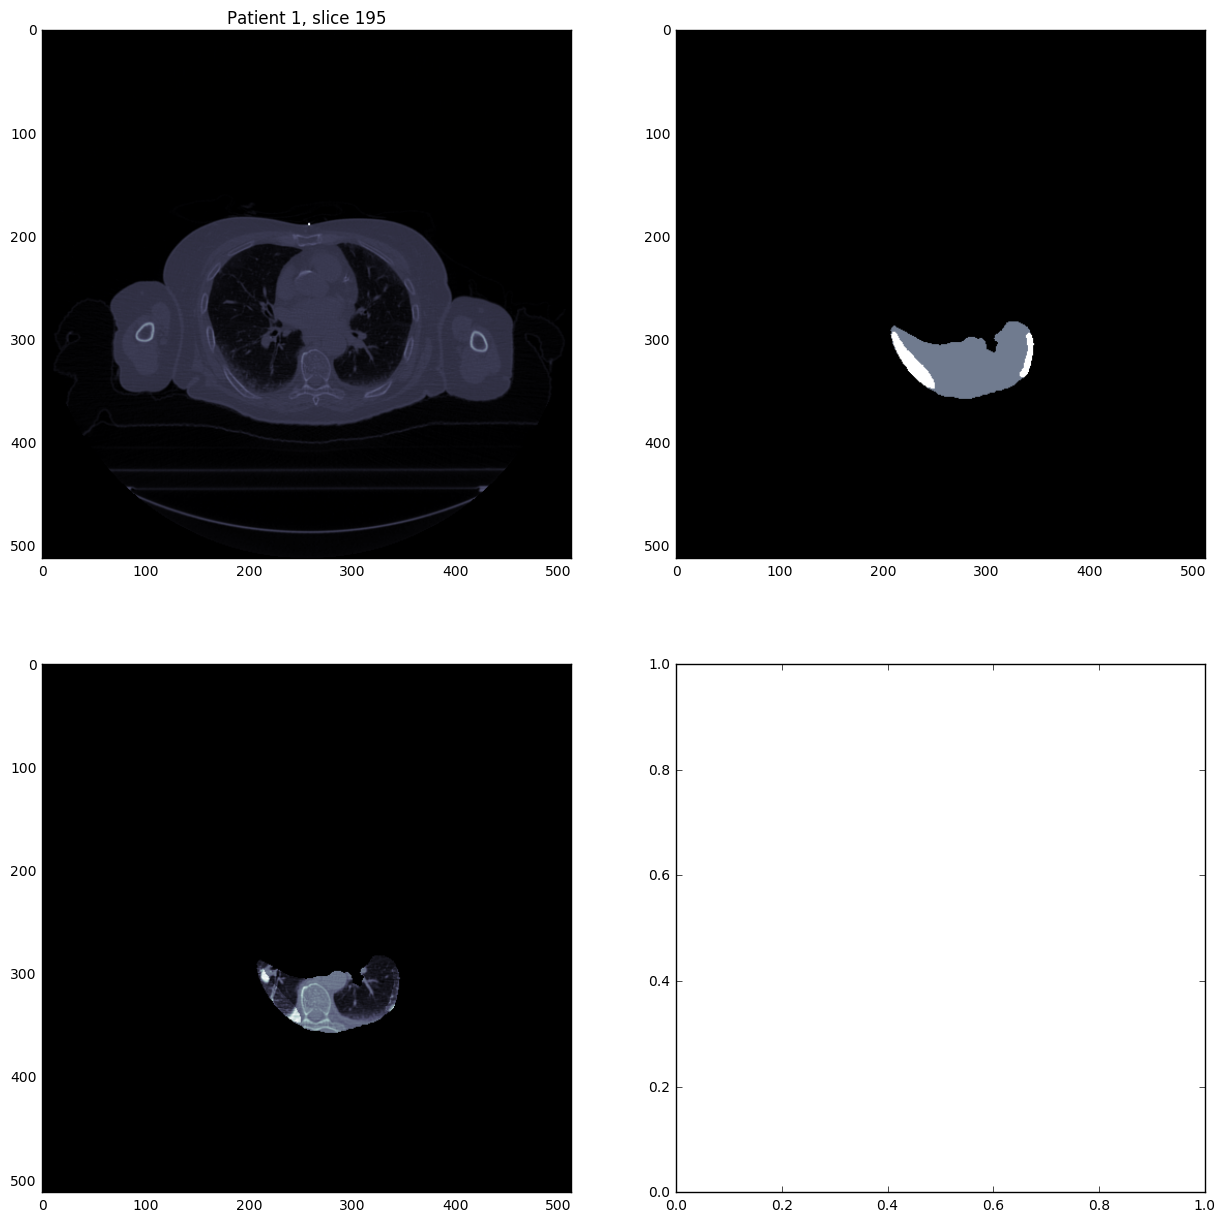

In [37]:
## Create 3D maps of the masks - uncomment if you have not created the dicom files.
#Example : DCM.CreatePatientMask('P3',NbSlicesOfPatient) # NbSlicesOfPatient

print "Loading patient..."

## Create lists with paths for each patients.
DicomFiles_Pat1 = list() 
DicomFiles_Pat1_Mask = list()

# I'm using my own local path as we're not gonna upload the images on github - everyone should change this to their own local path.
MikaelPath = "/Users/Mikael/Dropbox/PhD/Classes/IFT6390/Data_Project/patient" # This is my base path.
#MikaelPath = "D:\Dropbox\PhD\Classes\IFT6390\Data_Project\patient" # Mikaël PC.
DicomFiles_Pat1.append(MikaelPath + str(PATIENT) +"_images_anon")# Create full path of patient.
DicomFiles_Pat1_Mask.append(base_path + '/Structures/Dicom/' + 'P' + str(PATIENT) + MASK)# Create full path of patient mask.

# # Load 3D volume with CT data.
pat1 = DCM.import_patient(DicomFiles_Pat1)

# Load 3D volume mask.
pat1_mask = DCM.import_patient(DicomFiles_Pat1_Mask)
# Get the mask                : pat1_mask>0
# Get the fibrosis voxels     : pat1_mask==2
# Get the non-fibrosis voxels : pat1_mask==1

print "Done."

# IMAGE REBINNING - ONLY FOR THE SLICES OF INTEREST. ALSO MASKS THE IMAGES.
PATIENT_IMAGES_REBINNED_LIST = list()
for ii in range(N_GRAY_LEVELS.size):
    PATIENT_IMAGES_REBINNED = np.zeros(pat1.shape)    
    PATIENT_IMAGES_REBINNED[:,:,sl] = Maths.Equalize_and_Rebin_Image(pat1[:,:,sl],pat1_mask[:,:,sl],N_GRAY_LEVELS[ii])
    PATIENT_IMAGES_REBINNED_LIST.append(PATIENT_IMAGES_REBINNED)

# Display example slice.
showing_slice = 195
fig, ax = plt.subplots(2,2,figsize=(15,15))
ax[0,0].set_title("Patient 1, slice " + str(showing_slice))
ax[0,0].imshow(pat1[:,:,showing_slice], cmap=plt.cm.bone)
ax[0,1].imshow(pat1_mask[:,:,showing_slice], cmap=plt.cm.bone)
ax[1,0].imshow(np.multiply(pat1[:,:,showing_slice],pat1_mask[:,:,showing_slice]), cmap=plt.cm.bone)
plt.show()

## ========================
## TEXTURE ANALYSIS
## ========================

In [14]:
# Do the texture analysis for each rebinned image, each texture, and each gray levels.

#PATIENT_IMAGES_REBINNED_LIST

TEXTURE_MAP_LIST = list()

for ii in range(N_GRAY_LEVELS.size):
    
    print ii
    
    for jj in range(PATCH_SIZE.size):
        
        print jj
    
#        temp_textures = TextureFunctions.GetTextureMaps(pat1_mask,pat1,sl,PATCH_SIZE[jj],TEXTURES,N_GRAY_LEVELS[ii])
        temp_textures = TextureFunctions.GetTextureMaps(pat1_mask,PATIENT_IMAGES_REBINNED_LIST[ii],sl, \
                                                        PATCH_SIZE[jj],TEXTURES,N_GRAY_LEVELS[ii])
        
        TEXTURE_MAP_LIST.append(temp_textures)
            


0
0
Creating textures...
contrast done.
Done.
1
Creating textures...
contrast done.
Done.
2
Creating textures...
contrast done.
Done.
3
Creating textures...
contrast done.
Done.


IndexError: list index out of range

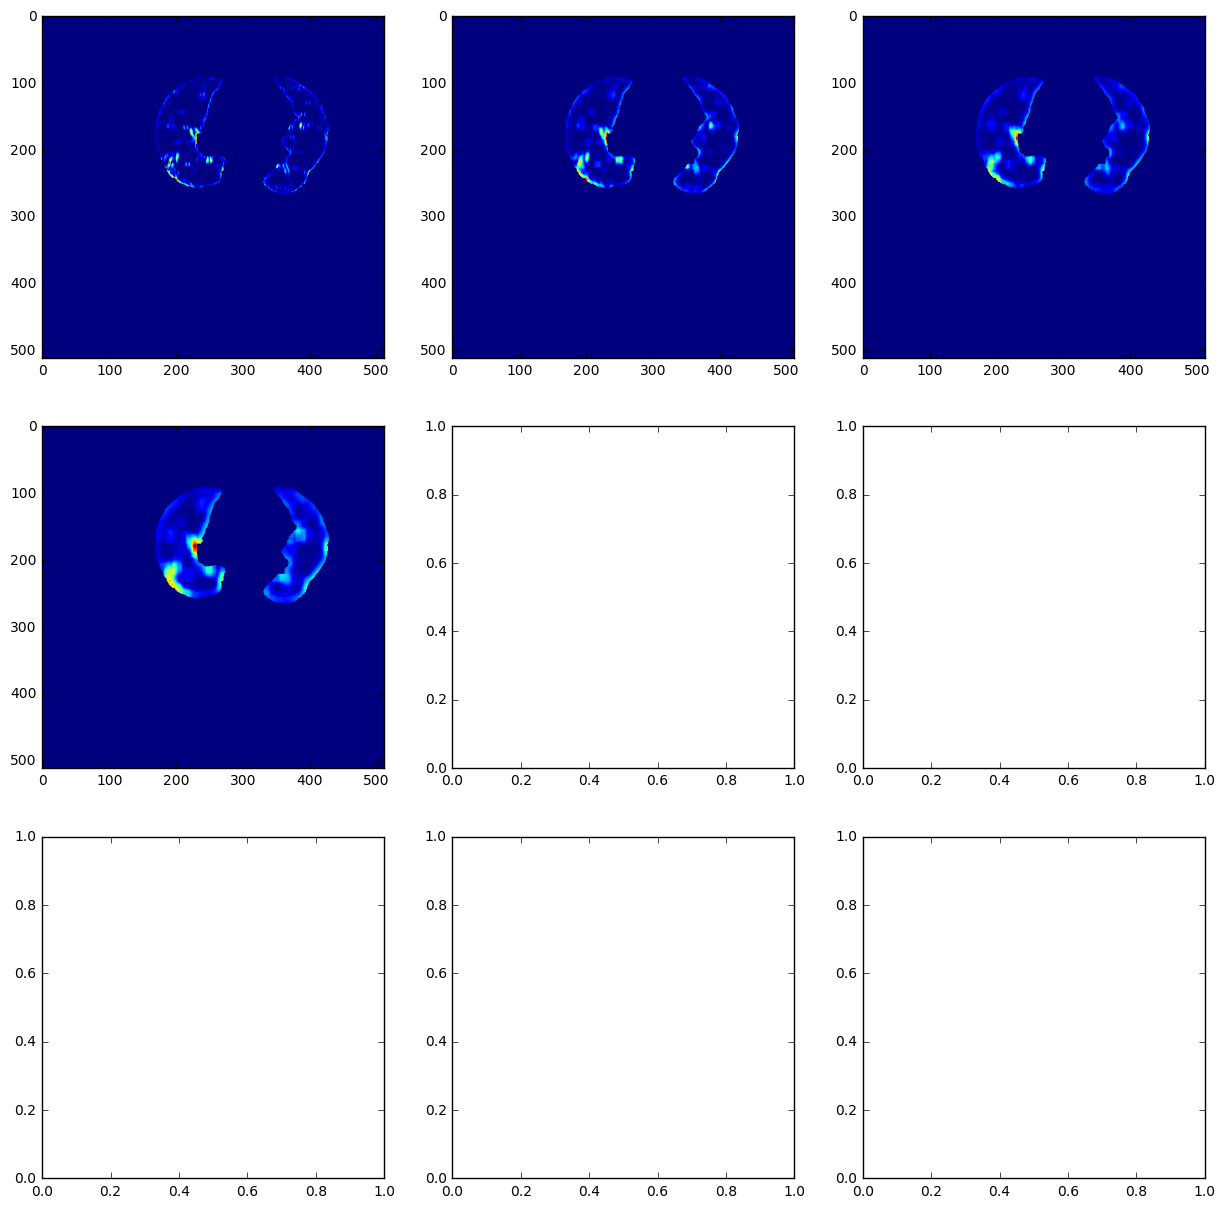

In [15]:
fig,ax= plt.subplots(3,3,figsize=(15,15))
zz = 0

ax[0,0].imshow(TEXTURE_MAP_LIST[0][:,:,sl[0],zz])

ax[0,1].imshow(TEXTURE_MAP_LIST[1][:,:,sl[0],zz])

ax[0,2].imshow(TEXTURE_MAP_LIST[2][:,:,sl[0],zz])

ax[1,0].imshow(TEXTURE_MAP_LIST[3][:,:,sl[0],zz])

ax[1,1].imshow(TEXTURE_MAP_LIST[4][:,:,sl[0],zz])

ax[1,2].imshow(TEXTURE_MAP_LIST[5][:,:,sl[0],zz])

ax[2,0].imshow(TEXTURE_MAP_LIST[6][:,:,sl[0],zz])




# Outputs of the code - create a .hd5 file with everything of interest.

In [84]:
## ONLY EXPORT THE DESIRED VOXELS.

NbCombinationParams = len(TEXTURE_MAP_LIST)
    
NbVox = np.sum(pat1_mask[:,:,sl].astype(bool))
restruct_map = np.zeros([NbVox,1+NbCombinationParams*TEXTURE_MAP_LIST[ii].shape[3]])
cpt = 0

for ii in range(NbCombinationParams):
    
    for i in range(TEXTURE_MAP_LIST[ii].shape[3]):
    
        #current_texture_map = texture_maps[:,:,sl,i]
        current_texture_map = TEXTURE_MAP_LIST[ii][:,:,sl,i]
        restruct_map[:,cpt] = current_texture_map[pat1_mask[:,:,sl].astype(bool)]   
        cpt += 1
    
mask = pat1_mask[:,:,sl]    
restruct_map[:,cpt] = mask[pat1_mask[:,:,sl].astype(bool)]

print "Here is the final shape of the array you will export:"
print restruct_map.shape

Here is the final shape of the array you will export:
(2682278, 19)


# =======================================
# SAVE TO HDF5 FILE.
# =======================================

In [85]:
# 

hyperparameters = {'N_GRAY_LEVELS': N_GRAY_LEVELS, 'PATCH_SIZE': PATCH_SIZE, 'TEXTURES': TEXTURES }

print 'IF THE FILE EXISTS, OPEN IT AS "r+" TO APPEND.'
print 'IF IT DOESNT EXIST, OPEN AS "w".'

with h5py.File('NGL_32_PATCH_36.h5','w') as hf:
    
    g1 = hf.create_group('patient_'+str(PATIENT)+str(MASK))
    g1.create_dataset('data',data=restruct_map,compression='gzip',compression_opts=9)
    g1.create_dataset('mask',data=mask.astype(uint16),compression='gzip',compression_opts=9)
    g1.create_dataset('slices',data=sl)
    
#    g1.create_dataset('hyperparameters',data=hyperparameters)
    
    hf.close()


IF THE FILE EXISTS, OPEN IT AS "r+" TO APPEND.
IF IT DOESNT EXIST, OPEN AS "w".


# =======================================
# BELOW : HOW TO LOAD HDF5 FILES.
# =======================================

In [23]:
#with h5py.File('NGL_32128_PATCH_5.h5','r') as hf:
#    print hf.keys()
#    gp1 = hf.get('patient_3')
    
    # LOAD THE DATA FOR ALL VOXELS.
#    patient_data_temp = gp1.get('data')
#    patient_data = np.array(patient_data_temp)
    
    # LOAD THE MASK AND THE SLICES, IF YOU WANT.
#    mask_tmp = gp1.get('mask')
#    mask = np.array(mask_tmp)
    
#    sl_tmp = gp1.get('slices')
#    sl = np.array(sl_tmp)
    
###mik : rajouter la concatenation de tous les patients avec tous les masques.
###s'assurer de append au fichier hd5 existant un novueau patient genre.


[u'patient_1a', u'patient_2a', u'patient_3']


# =======================================
# BELOW : TO USE ONCE ML IS PERFORMED 
# =======================================

(2682278, 82)


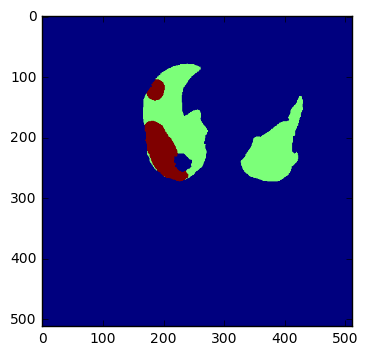

In [14]:
#######
## RECONSTRUCTION OF MAPS FROM restruct_map array - to use later! We will reconstruct the "best fitted" y.

#map_reconstructed = np.zeros(pat1_mask[:,:,sl].shape)

#map_reconstructed[pat1_mask[:,:,sl].astype(bool)] = patient_data[:,-1]


#print patient_data.shape # THIS IS WHAT WE WILL TRAIN/TEST.



# Where we would use, instead, the "best fit restruct map".


#plt.imshow(map_reconstructed[:,:,150])

